# Follow-up Task for Hazy

First we need to obtain some data. This needs to be a list of jobs and/or job types. I found such a list on the ONET website: https://www.onetcenter.org/database.html. I've put the tidied csv file in my Github repository for use alongside this document. There were also job descriptions in this database which could be useful in the future, but for now we concentrate on just the job names.

The first part of my approach to this task is to create an embedding for each job name. We could try and build our own model to do this, but why reinvent the wheel? Let's use a pre-existing model! How about GloVe - the version I chose to use contains word embeddings trained on over 400k words and their associations as found in context on Wikipedia (2014) and Gigaword 5 (a newswire text data archive). More on GloVe here: https://nlp.stanford.edu/projects/glove/. You will need to download the 6B version files from the link just provided in order to successfully run the code in this notebook.

So my approach is, when the word in the job name exists in GloVe, to use their word embedding. If not, we just use a random embedding. For jobs with more than one word we can simply use the sum of the embeddings of the constituent words.

After some data cleaning I create a dictionary of the job names along with their word embeddings. Then we can visualise in 2D the job associations - not perfect but gives us an idea.

Then, for a given job name, I find the nearest jobs in the (50-dimensional) hyperspace around it by performing a sort by descending cosine similarity (this gives a good measure of how close the word vectors/embeddings are). Then lastly we randomly choose one of these nearest neighbours to reassign ("anonymise") our original job.

In [4]:
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
%matplotlib inline
import utils; reload(utils)
reload(utils)
from utils import plots
from utils import *
from __future__ import division, print_function
import csv
import string
import random

Using TensorFlow backend.
/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Some data cleaning:

In [5]:
output_file = open('Jobs_tidied_row_nos.csv', 'w')
writer = csv.writer(output_file)

with open('List_of_jobs_ONET.csv', 'rU') as f:
    for row in enumerate(f,start=1):
  
        row = str(row)
        row = row.replace('"' , '')
        row = row[:-4]
        row = row[1:]
        row = row.replace("'" , "")
        row = row.replace('"' , '')

        writer.writerow([row])
        

Load GloVe data:

In [3]:
def load_glove(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

In [4]:
res_path = ''
cwd = os.getcwd()
cwd

'/Users/pf113/Documents/Data Science/Task_for_Luke'

In [5]:
vecs, words, wordidx = load_glove(res_path +'6B.50d')

In [237]:
vecs.shape

(400000, 50)

In [238]:
#look up the first 25 words in glove - just to be curious!
' '.join(words[:25])

'the , . of to and in a " \'s for - that on is was said with he as it by at ( )'

In [239]:
#can look up a word vector, if we need

def w2v(w): return vecs[wordidx[w]]

In [240]:
#e.g.:

w2v('chief')

array([ 2.4444e-01, -1.6053e-01,  6.6681e-02,  1.0138e+00,  1.1697e+00, -8.3291e-01, -3.1749e-01,
       -1.4103e-03,  4.6096e-02, -1.6956e+00,  3.9535e-01,  9.7831e-01, -1.5315e+00,  4.1920e-02,
        1.8251e-01,  4.3828e-01,  1.8746e-02,  4.3894e-01,  5.7750e-02, -7.6984e-02,  1.9547e-01,
        1.2758e-01, -5.6895e-01, -4.8464e-01, -8.1186e-01, -2.3198e+00, -2.0311e-01, -4.0964e-01,
       -1.7205e+00,  1.0985e+00,  2.2903e+00, -7.2011e-01, -2.7931e-01, -3.6026e-01,  1.3228e-02,
       -4.3625e-01, -2.4718e-01, -4.3086e-01,  7.8072e-01,  2.4224e-01, -2.7596e-01,  1.3542e+00,
       -6.4568e-01, -7.7009e-01,  6.6655e-01,  2.1232e-02, -1.0171e+00,  7.4007e-01,  1.9035e-01,
        1.0739e+00], dtype=float32)

In [241]:
reload(sys)
sys.setdefaultencoding('utf8')

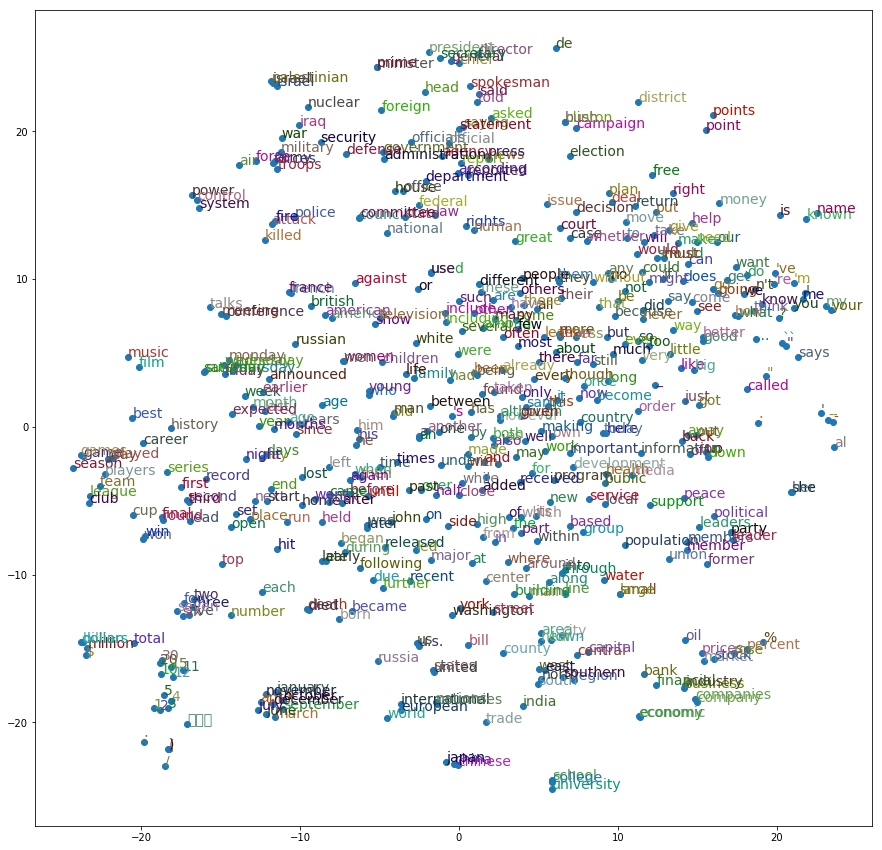

In [242]:
#we can plot (in 2D) the first 500 words of GloVe, out of interest

tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(vecs[:500])

start=0; end=500
dat = Y[start:end]
plt.figure(figsize=(15,15))
plt.scatter(dat[:, 0], dat[:, 1])
for label, x, y in zip(words[start:end], dat[:, 0], dat[:, 1]):
    plt.text(x,y,label, color=np.random.rand(3)*0.7,
                 fontsize=14)
plt.show()

From this we can see that President and Minister are very close - good!

So let's assign these word embeddings to the word(s) in our job names:

In [7]:
#may need to run this cell twice

csv.field_size_limit(sys.maxsize)

9223372036854775807

In [8]:
cwd = os.getcwd()
cwd

'/Users/pf113/Documents/Data Science/Task_for_Luke'

More cleaning:

In [9]:
output_file = open('Jobs_column_nos_only.csv', 'w')
writer = csv.writer(output_file)

job_id = []
job_name = []

with open('Jobs_tidied_row_nos.csv', 'rb') as csvfile:
    
    for line in csvfile:
        
        line = line.replace('"' , '')
        line = line.replace('\r\n' , '')
        columns = line.split(', ')

        col = columns[0]

        job = columns[1]
        job = job.lower()
        col = str(col)
        job = str(job)
        
        writer.writerow([col])
        
        idx = col
        
        job_id.append(idx)
        job_name.append(job)

jobs_and_ids = zip(job_name, job_id)       


for i,jb in jobs_and_ids:

    job_dict = dict(jobs_and_ids)

    
def lower_dict(d):
    
    new_dict = dict((k.lower(), v.lower()) for k, v in job_dict.iteritems())
    
    return new_dict


In [10]:
idx2word = {v: k for k, v in dict(lower_dict(job_dict)).iteritems()}

print(idx2word["10"])

administrative services managers


In [11]:
word = idx2word.values()

In [12]:
import re
vocab_size = 1055

def create_emb():
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))
    print(len(emb))
    word_embedding_dict = {}

    for i in range(1,len(emb)):

                        job_name = idx2word.values()[i]

                        job_name = str(job_name)
            
                        divided_word = job_name.split(" ")
                    
                        print(divided_word)
                    
                        length = len(divided_word)

                        
                        for j in range(length):
                        
                            divided_word[j] = str(divided_word[j])

                            if divided_word[j] in words and re.match(r"^[a-zA-Z0-9\-]*$", divided_word[j]):
                                
                                src_idx = wordidx[divided_word[j]]
                                
                                print("Divided word: "  , divided_word[j] , "is in GloVe" )
                                
                                print(vecs[src_idx])
                                
                                emb[j] = vecs[src_idx]
   
                            else:
                                    
                                print("Divided word: "  , divided_word[j] , "is NOT in GloVe" )

                                emb[j] = normal(scale=0.6, size=(n_fact,))

                        emb[i] = sum(emb[j] for j in range(length))        

                        print("END OF J LOOP")

                        emb[i] = np.array(emb[i])

                        word_embedding_dict[job_name] = emb[i]

    emb[-1] = normal(scale=0.6, size=(n_fact,))

    emb/=3


    return emb, word_embedding_dict

In [1]:
emb,word_embedding_dict = create_emb()

Great! So we now have our embeddings (word vectors). Let's plot some of them in 2D.

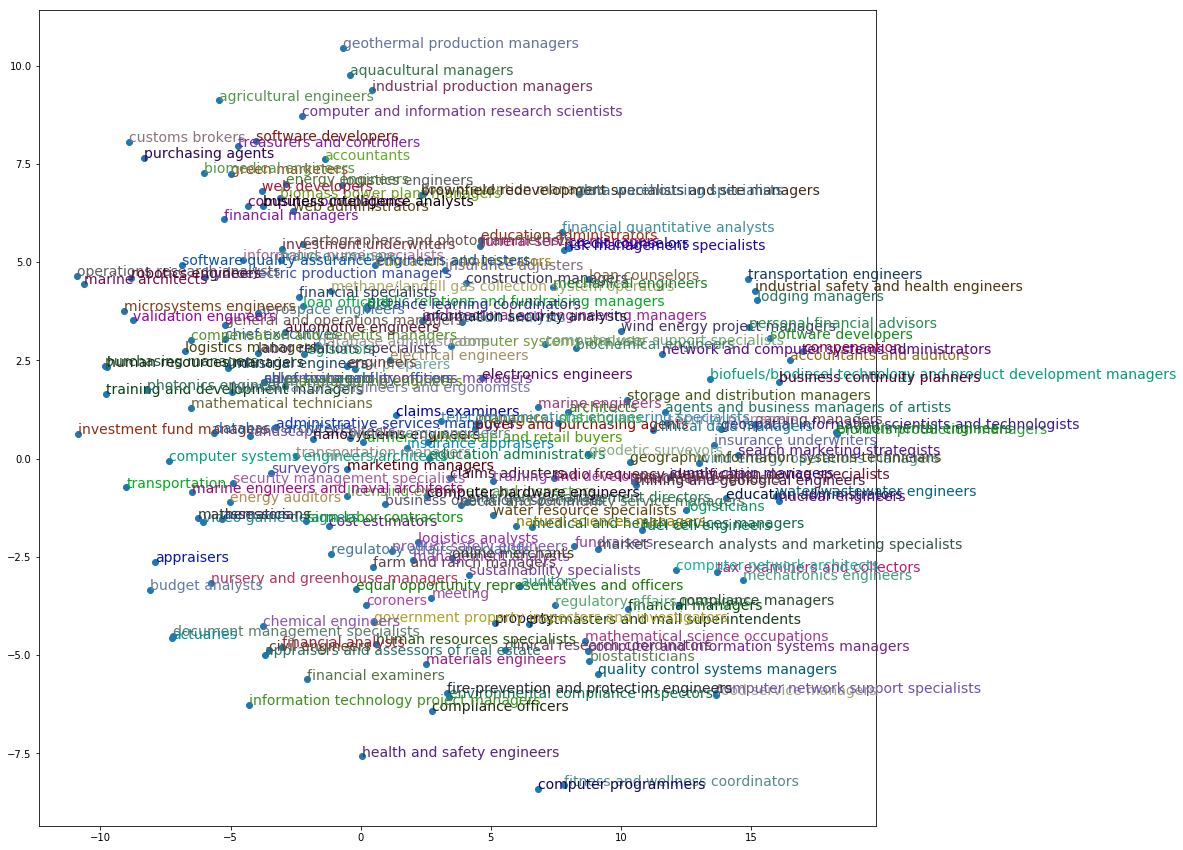

In [14]:
#plot in 2D the first 200 words

tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(emb[:200])

start=0; end=200
dat = Y[start:end]
plt.figure(figsize=(15,15))
plt.scatter(dat[:, 0], dat[:, 1])
for label, x, y in zip(job_name[start:end], dat[:, 0], dat[:, 1]):
    plt.text(x,y,label, color=np.random.rand(3)*0.7,
                 fontsize=14)
plt.show()

Okay not bad - some teachers and some managers are grouped together which is good! Now let's do the anonymising. A good way to compare word vectors is using the cosine similarity.

In [45]:
def vector_len(v):
    return math.sqrt(sum([x*x for x in v]))

def dot_product(v1, v2):
    #assert len(v1) == len(v2)
    return sum([x*y for (x,y) in zip(v1, v2)])

def cosine_similarity(v1, v2):
    """
    Returns the cosine of the angle between the two vectors.
    Results range from -1 (very different) to 1 (very similar).
    """
    
    return dot_product(v1, v2) / (vector_len(v1) * vector_len(v2))


def calc_ordered_cosine_sim(my_dict):    
    
    result_trim = {}
    result = {}

    for key,value in my_dict.items():
        temp,tempDict= 0,{}
        for keyC,valueC in my_dict.items():
            if keyC == key:
                continue
        
            temp = cosine_similarity(value,valueC)

            tempDict[keyC] =temp
    
        tempDict = sorted(tempDict.items(), key=lambda x: x[1], reverse=True)
    
        result[key] = tempDict
        
    
    return (result)
    

def randomise(my_dict,job):

    MAX_RESULTS = 5
    
    job_cos_sim_dict = dict(my_dict.items()[job][:MAX_RESULTS])
    
    return job_cos_sim_dict


In [32]:
request = raw_input("Enter the job name you want to anonymise (must be all lower case and in ONET database): ")
print('The job name you want to anonymise is:', request)

Enter the job name you want to anonymise (must be all lower case and in ONET database): marine engineers and naval architects
The job name you want to anonymise is: marine engineers and naval architects


In [60]:
job_to_anon=[]
job_to_anon.append(request)
job_to_anon = str(job_to_anon)
job_to_anon = job_to_anon.replace("[", "")
job_to_anon = job_to_anon.replace("]", "")
job_to_anon = job_to_anon.replace("'", "")
print (job_to_anon)

#note: should probably put in some if statements here to make sure the raw input conditions have been met.

marine engineers and naval architects


In [2]:
calc_ordered_cosine_sim(word_embedding_dict)

In [56]:
result = calc_ordered_cosine_sim(word_embedding_dict)

In [58]:
def trim(my_dict,job):

    MAX_RESULTS = 10
    
    result_trim = my_dict[job][:MAX_RESULTS]
    
    return result_trim

In [61]:
trim(result,job_to_anon)

[('marine engineers', 0.9351080002092154),
 ('marine architects', 0.9169645578614349),
 ('aerospace engineering and operations technicians', 0.8613475655795797),
 ('civil engineers', 0.856054366717162),
 ('ship engineers', 0.8470217518109008),
 ('military enlisted tactical operations and air/weapons specialists and crew members',
  0.8464788578248315),
 ('mining and geological engineers', 0.8450623962101077),
 ('civil engineering technicians', 0.842329270093341),
 ('aircraft mechanics and service technicians', 0.8404862430888229),
 ('engineers', 0.8368263297784674)]

In [62]:
result_trim = trim(result,job_to_anon)

In [73]:
def randomise(my_list):
    
    key1 = random.sample(my_list, 1)

    return key1

randomise(result_trim)

new_anon_job = dict(randomise(result_trim))

print('You have successfully anonymised the job:', job_to_anon , "to: " , new_anon_job.keys())

print('The cosine similarity of the newly anonymised job compared to the original job is: ' , new_anon_job.values())

You have successfully anonymised the job: marine engineers and naval architects to:  ['aircraft mechanics and service technicians']
The cosine similarity of the newly anonymised job compared to the original job is:  [0.8404862430888229]


And this is our anonymised job, along with it's cosine similarity to the original job name.

# Some final thoughts

1. We could have used a higher dimensional embedding - GloVe also have one in 300D! This has been trained on a larger corpus.
2. We could envisage at some point building our own original embeddings, rather than using the pre-trained ones from GloVe. This could be tailored to jobs/addresses/post codes etc. I would need to sit down and think how to do this but in theory it is doable.
3. We might like to exclude common words like "and' and "or" in the embedding creation phase - this would be a relatively simple task.
4. We could also look at weighting certain words within the embedding creation phase - e.g. for "science teachers" we should probably put more weight on "teachers" if we want to make sure other teachers are nearby in the hyperspace.
5. In terms of Luke's original question, the "blur matrix" is basically the ranked cosine similarity. It is "parametrised" by the variable MAX_RESULTS as defined in the function "trim".
6. Rather than setting a limit on MAX_RESULTS we could just trim our results above a fixed value of the cosine similarity, but this is probably less elegant.
7. A cosine similarity of 1 is a complete match.

I will do some more thinking about how all this relates to anonymisation, how it can be extended to other identifiers etc for when we meet next.
